In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3090
1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
#import seaborn as sns
import random
import time
import os
import copy

import torch.nn as nn
import os
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from torchvision.transforms.functional import crop
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, average_precision_score
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
criterion = nn.CrossEntropyLoss().cuda()

## model weight path

In [7]:
bipolar_50 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan50/bipolar2_weight_test_auc_0.8733459357277884.pt'
depressive_50 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan50/depressive_weight_test_auc_0.8395061728395061.pt'
schizo_50 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan50/Schizophrenia_weight_test_auc_0.9339080459770115.pt'

In [8]:
bipolar_200 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan200/bipolar_weight_test_auc_0.9741379310344827.pt'
depressive_200 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan200/depressive_weight_test_auc_0.9573232323232324.pt'
schizo_200 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan200/Schizophrenia_weight_test_auc_0.9587011349306431.pt'

In [98]:
bipolar_raw = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/raw data/bipolar_weight_test_auc_0.6848484848484848.pt'
depressive_raw = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/raw data/depressive_weight_test_auc_0.796875.pt'
schizo_raw = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/raw data/Schizophrenia_weight_test_auc_0.8148148148148149.pt'

In [10]:
bipolar_100 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan100/bipolar_weight_test_auc_0.9614661654135339.pt'
depressive_100 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan100/depressive_weight_test_auc_0.9361702127659575.pt'
schizo_100 = 'C:/Users/232STG21/Documents/EEG/Final model_resnet34F/cdcgan100/Schizophrenia_weight_test_auc_0.9592760180995475.pt'

## Bipolar

In [103]:
bp_roc_auc = []
bp_fprtpr=[]

In [114]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(bipolar_200))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [115]:
dataset_path = 'C:/Users/232STG21/Documents/EEG/cDCGAN_200/raw+gan건강조울'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
}

# train/val(test)일때 각각 transform된 image_datasets 생성
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5, shuffle=False, num_workers=2)

In [116]:
test_labels = list()
test_preds_prob = list()
for idx, (test_img, test_label) in enumerate(test_loader):

    test_img, test_label = test_img.to(device), test_label.to(device)
    output = model_ft(test_img)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]

    for j in test_label:
        test_labels.append(j.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
bp_fprtpr.append([fpr, tpr])
bp_roc_auc.append(metrics.auc(fpr, tpr))
#print(fprtpr)
print(bp_roc_auc)

[0.6353383458646616, 0.7255639097744361, 0.6691729323308271, 0.7030075187969925]


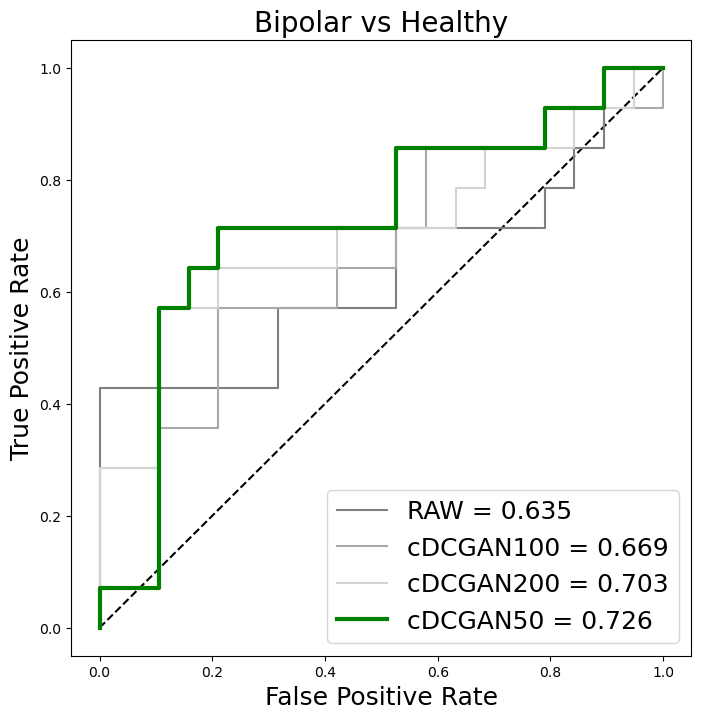

In [147]:
plt.figure(facecolor="w",figsize=(8,8))

plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(bp_fprtpr[0][0], bp_fprtpr[0][1], marker='.', color='gray', markersize=0.02, label="RAW = %.3f" % bp_roc_auc[0])
plt.plot(bp_fprtpr[2][0], bp_fprtpr[2][1], marker='.', color='darkgray', markersize=0.02, label="cDCGAN100 = %.3f" % bp_roc_auc[2])
plt.plot(bp_fprtpr[3][0], bp_fprtpr[3][1], marker='.', color='lightgray', markersize=0.02, label="cDCGAN200 = %.3f" % bp_roc_auc[3])

best_fpr, best_tpr = bp_fprtpr[1][0], bp_fprtpr[1][1]
plt.plot(best_fpr, best_tpr, marker='.', color='green', linewidth=3, markersize=0.05, label="cDCGAN50 = %.3f" % bp_roc_auc[1])

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Bipolar vs Healthy', fontdict = {'fontsize' : 20})
plt.legend(loc=4, fontsize=18)

plt.show()

## Depressive

In [132]:
dp_roc_auc = []
dp_fprtpr=[]

In [142]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(depressive_200))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [143]:
dataset_path = 'C:/Users/232STG21/Documents/EEG/cDCGAN_200/raw+gan건강우울'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
}

# train/val(test)일때 각각 transform된 image_datasets 생성
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5, shuffle=False, num_workers=2)

In [144]:
test_labels = list()
test_preds_prob = list()
for idx, (test_img, test_label) in enumerate(test_loader):

    test_img, test_label = test_img.to(device), test_label.to(device)
    output = model_ft(test_img)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]

    for j in test_label:
        test_labels.append(j.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
dp_fprtpr.append([fpr, tpr])
dp_roc_auc.append(metrics.auc(fpr, tpr))
#print(fprtpr)
print(dp_roc_auc)

[0.6776315789473685, 0.6171052631578947, 0.6934210526315789, 0.6881578947368421]


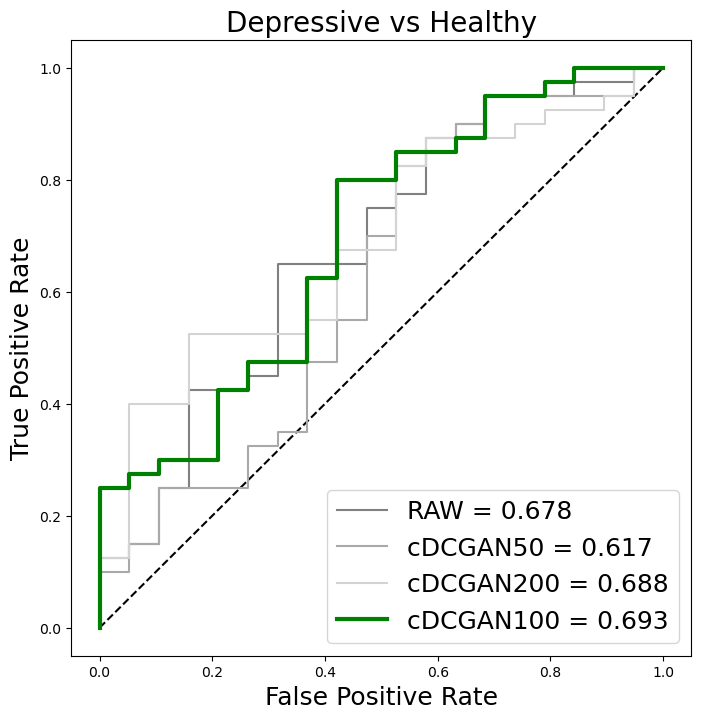

In [162]:
plt.figure(facecolor="w",figsize=(8,8))

plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(dp_fprtpr[0][0], dp_fprtpr[0][1], marker='.', color='gray', markersize=0.02, label="RAW = %.3f" % dp_roc_auc[0])
plt.plot(dp_fprtpr[1][0], dp_fprtpr[1][1], marker='.', color='darkgray', markersize=0.02, label="cDCGAN50 = %.3f" % dp_roc_auc[1])
plt.plot(dp_fprtpr[3][0], dp_fprtpr[3][1], marker='.', color='lightgray', markersize=0.02, label="cDCGAN200 = %.3f" % dp_roc_auc[3])

plt.plot(dp_fprtpr[2][0], dp_fprtpr[2][1], marker='.', color='green', linewidth=3, markersize=0.02, label="cDCGAN100 = %.3f" % dp_roc_auc[2])

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Depressive vs Healthy', fontdict = {'fontsize' : 20})
plt.legend(loc=4, fontsize=18)

plt.show()

## Schizo

In [148]:
sc_roc_auc = []
sc_fprtpr=[]

In [158]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(schizo_200))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [159]:
dataset_path = 'C:/Users/232STG21/Documents/EEG/cDCGAN_200/raw+gan건강조현'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
}

# train/val(test)일때 각각 transform된 image_datasets 생성
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5, shuffle=False, num_workers=2)

In [160]:
test_labels = list()
test_preds_prob = list()
for idx, (test_img, test_label) in enumerate(test_loader):

    test_img, test_label = test_img.to(device), test_label.to(device)
    output = model_ft(test_img)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]

    for j in test_label:
        test_labels.append(j.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
sc_fprtpr.append([fpr, tpr])
sc_roc_auc.append(metrics.auc(fpr, tpr))
#print(fprtpr)
print(sc_roc_auc)

[0.8245614035087719, 0.6228070175438597, 0.8903508771929826, 0.7587719298245613]


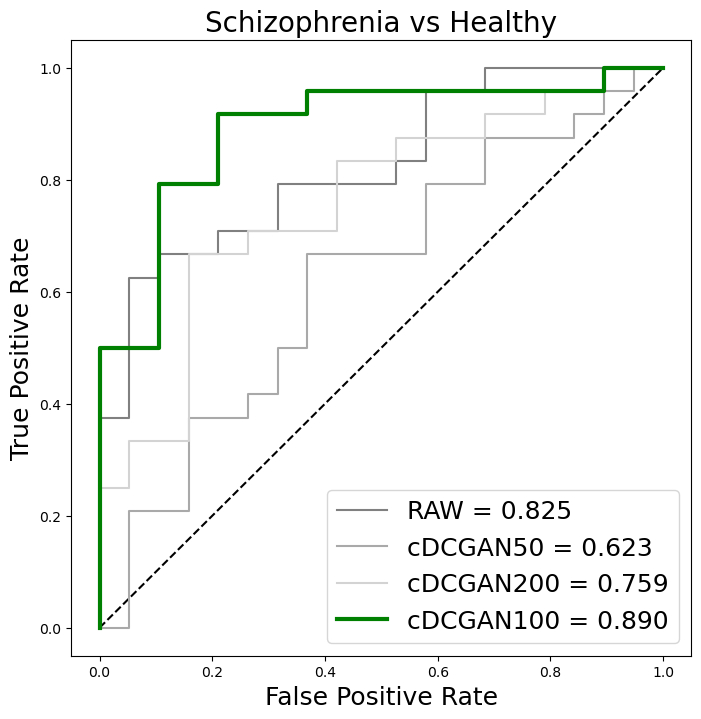

In [163]:
plt.figure(facecolor="w",figsize=(8,8))

plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(sc_fprtpr[0][0], sc_fprtpr[0][1], marker='.', color='gray', markersize=0.02, label="RAW = %.3f" % sc_roc_auc[0])
plt.plot(sc_fprtpr[1][0], sc_fprtpr[1][1], marker='.', color='darkgray', markersize=0.02, label="cDCGAN50 = %.3f" % sc_roc_auc[1])
plt.plot(sc_fprtpr[3][0], sc_fprtpr[3][1], marker='.', color='lightgray', markersize=0.02, label="cDCGAN200 = %.3f" % sc_roc_auc[3])

plt.plot(sc_fprtpr[2][0], sc_fprtpr[2][1], marker='.', color='green', linewidth=3, markersize=0.02, label="cDCGAN100 = %.3f" % sc_roc_auc[2])

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Schizophrenia vs Healthy', fontdict = {'fontsize' : 20})
plt.legend(loc=4, fontsize=18)

plt.show()